# Baseline Models: XGBoost & LightGBM for Next Purchase Prediction

This notebook implements baseline recommendation models using traditional ML approaches:

## Approach:
1. **Candidate Generation** - Create candidate set of products for each user
2. **Feature Engineering** - Combine user, item, and interaction features  
3. **Dataset Creation** - Binary classification: user will buy this product next?
4. **Baseline Models** - Train multiple models and compare performance
5. **Evaluation** - Precision@K, Recall@K, MAP@K metrics

## Models Implemented:
- **Popularity Model** - Simple popularity-based recommendations
- **Recency Model** - Recent purchase history based 
- **XGBoost** - Gradient boosting with feature importance analysis
- **LightGBM** - Fast gradient boosting for comparison

## Outputs:
- `data/splits/` - Train/validation/test splits
- `models/archived/` - Model checkpoints and artifacts
- Comprehensive model evaluation and feature importance analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
from tqdm.auto import tqdm
import gc
import os
from collections import defaultdict
import pickle

# Configure settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
warnings.filterwarnings('ignore')
plt.style.use('default')

print("Libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")

Libraries imported successfully!
XGBoost version: 3.0.5
LightGBM version: 4.6.0


## 1. Data Loading and Setup

In [2]:
# Define paths
DATA_RAW_PATH = "../data/raw/"
DATA_FEATURES_PATH = "../data/features/"
DATA_SPLITS_PATH = "../data/splits/"
MODELS_PATH = "../models/"

# Create directories
os.makedirs(DATA_SPLITS_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

print("Loading feature datasets...")

# Load engineered features
try:
    user_features = pd.read_parquet(DATA_FEATURES_PATH + "user_features_with_rfm.parquet")
    item_features = pd.read_parquet(DATA_FEATURES_PATH + "item_features.parquet")
    user_item_features = pd.read_parquet(DATA_FEATURES_PATH + "user_item_features.parquet")
    print("✓ All feature datasets loaded successfully")
except FileNotFoundError as e:
    print(f"Error loading features: {e}")
    print("Please run the feature engineering notebook first (02_feature_engineering.ipynb)")
    raise

# Load raw data for candidate generation
orders = pd.read_csv(DATA_RAW_PATH + "orders.csv")
order_products_train = pd.read_csv(DATA_RAW_PATH + "order_products__train.csv")

print(f"✓ User features: {user_features.shape}")
print(f"✓ Item features: {item_features.shape}")
print(f"✓ User-item features: {user_item_features.shape}")
print(f"✓ Orders: {orders.shape}")
print(f"✓ Train order products: {order_products_train.shape}")

print("\nData loaded successfully!")

Loading feature datasets...
✓ All feature datasets loaded successfully
✓ User features: (206209, 37)
✓ Item features: (49688, 25)
✓ User-item features: (13863746, 14)
✓ Orders: (3421083, 7)
✓ Train order products: (1384617, 4)

Data loaded successfully!


## 2. Candidate Generation Strategy

Create candidate sets for each user - products they might purchase next.

In [3]:
print("Creating candidate generation strategy...")

# Step 1: Get users who have train orders (target users)
train_users = orders[orders['eval_set'] == 'train']['user_id'].unique()
print(f"Users with train orders (our target users): {len(train_users):,}")

# Step 2: Create positive samples - products actually purchased in train set
train_orders = orders[orders['eval_set'] == 'train'][['order_id', 'user_id']]
positive_samples = train_orders.merge(order_products_train[['order_id', 'product_id']], on='order_id')

print(f"Positive samples (actual purchases): {positive_samples.shape[0]:,}")

# Step 3: For each user, create candidate set based on:
# - Products they've purchased before (reorder candidates)  
# - Popular products they haven't tried yet
# - Products in same categories as their purchase history

def generate_candidates_for_user(user_id, n_reorder_candidates=20, n_popular_candidates=30):
    """Generate candidate products for a user"""
    
    # Get user's purchase history (from user_item_features)
    user_history = user_item_features[user_item_features['user_id'] == user_id]['product_id'].tolist()
    
    # Reorder candidates: products user has bought before
    reorder_candidates = user_history[:n_reorder_candidates]  # Take top by frequency
    
    # Popular candidates: highly popular products user hasn't tried
    user_history_set = set(user_history)
    
    # Get top popular products globally (excluding user's history)
    popular_products = item_features.sort_values('item_total_orders', ascending=False)
    popular_candidates = []
    
    for _, row in popular_products.iterrows():
        if len(popular_candidates) >= n_popular_candidates:
            break
        if row['product_id'] not in user_history_set:
            popular_candidates.append(row['product_id'])
    
    # Combine candidates
    all_candidates = list(set(reorder_candidates + popular_candidates))
    
    return all_candidates

# Test candidate generation for a few users
sample_users = train_users[:3]
print("\\nTesting candidate generation:")
for user_id in sample_users:
    candidates = generate_candidates_for_user(user_id)
    print(f"User {user_id}: {len(candidates)} candidates")

Creating candidate generation strategy...
Users with train orders (our target users): 131,209
Positive samples (actual purchases): 1,384,617
\nTesting candidate generation:
User 1: 49 candidates
User 2: 50 candidates
User 5: 50 candidates


## 3. Dataset Creation for Binary Classification

Create training dataset: for each user-product pair, predict if user will purchase next.

In [4]:
print("Creating dataset for binary classification...")

# For efficiency, let's work with a sample of users first
SAMPLE_SIZE = 10000  # Sample 10K users for faster prototyping
sample_train_users = np.random.choice(train_users, size=min(SAMPLE_SIZE, len(train_users)), replace=False)

print(f"Working with sample of {len(sample_train_users):,} users")

# Create training dataset
training_data = []

# Create positive and negative labels dictionary for fast lookup
positive_user_products = positive_samples.groupby('user_id')['product_id'].apply(set).to_dict()

print("Generating candidate pairs...")
for user_id in tqdm(sample_train_users[:1000], desc="Processing users"):  # Start with 1K users
    # Generate candidates for this user
    candidates = generate_candidates_for_user(user_id, n_reorder_candidates=15, n_popular_candidates=20)
    
    # Get actual purchases for this user in train set
    actual_purchases = positive_user_products.get(user_id, set())
    
    # Create user-product pairs with labels
    for product_id in candidates:
        label = 1 if product_id in actual_purchases else 0
        training_data.append({
            'user_id': user_id,
            'product_id': product_id, 
            'label': label
        })

# Convert to DataFrame
training_df = pd.DataFrame(training_data)

print(f"\\nTraining dataset created:")
print(f"Total samples: {len(training_df):,}")
print(f"Positive samples: {training_df['label'].sum():,}")
print(f"Negative samples: {(training_df['label'] == 0).sum():,}")
print(f"Positive rate: {training_df['label'].mean():.3%}")

# Display sample
display(training_df.head())

Creating dataset for binary classification...
Working with sample of 10,000 users
Generating candidate pairs...


Processing users:   0%|          | 0/1000 [00:00<?, ?it/s]

\nTraining dataset created:
Total samples: 34,398
Positive samples: 2,761
Negative samples: 31,637
Positive rate: 8.027%


,user_id,product_id,label
0,129910,34050,0
1,129910,24964,0
2,129910,8575,0
3,129910,45066,0
4,129910,21903,0


In [5]:
# Merge with features to create final dataset
print("Merging with engineered features...")

# Merge with user features
dataset = training_df.merge(user_features, on='user_id', how='left')
print(f"After user features: {dataset.shape}")

# Merge with item features
dataset = dataset.merge(item_features, on='product_id', how='left')
print(f"After item features: {dataset.shape}")

# Merge with user-item interaction features (if available)
dataset = dataset.merge(user_item_features, on=['user_id', 'product_id'], how='left')
print(f"After user-item features: {dataset.shape}")

# Handle missing values for new user-item pairs (no interaction history)
print("\\nHandling missing values...")
print("Missing values before filling:")
print(dataset.isnull().sum().sum())

# Fill missing user-item features with zeros (indicates no previous interaction)
ui_feature_cols = [col for col in dataset.columns if col.startswith('ui_')]
dataset[ui_feature_cols] = dataset[ui_feature_cols].fillna(0)

# Fill any remaining missing values
dataset = dataset.fillna(0)

print("Missing values after filling:")
print(dataset.isnull().sum().sum())

print(f"\\nFinal dataset shape: {dataset.shape}")
print(f"Feature columns: {dataset.shape[1] - 3}")  # -3 for user_id, product_id, label

# Show sample with features
display(dataset[['user_id', 'product_id', 'label', 'user_total_orders', 'item_total_orders', 'ui_times_bought']].head())

Merging with engineered features...
After user features: (34398, 39)
After item features: (34398, 63)
After user-item features: (34398, 75)
\nHandling missing values...
Missing values before filling:
240000
Missing values after filling:
0
\nFinal dataset shape: (34398, 75)
Feature columns: 72


,user_id,product_id,label,user_total_orders,item_total_orders,ui_times_bought
0,129910,34050,0,5,17568.0,1.0
1,129910,24964,0,5,113936.0,0.0
2,129910,8575,0,5,2084.0,1.0
3,129910,45066,0,5,83320.0,0.0
4,129910,21903,0,5,251705.0,0.0


## 4. Feature Preparation and Train-Test Split

In [6]:
print("Preparing features for modeling...")

# Define feature columns (exclude IDs and target)
exclude_cols = ['user_id', 'product_id', 'label']
categorical_cols = ['Segment', 'department', 'aisle']  # Categorical features
text_cols = ['product_name']  # Text features to exclude from training

# Get feature columns
feature_cols = [col for col in dataset.columns if col not in exclude_cols + categorical_cols + text_cols]
print(f"Total feature columns: {len(feature_cols)}")

# Handle categorical features with label encoding
label_encoders = {}
for col in categorical_cols:
    if col in dataset.columns:
        le = LabelEncoder()
        dataset[f'{col}_encoded'] = le.fit_transform(dataset[col].astype(str))
        feature_cols.append(f'{col}_encoded')
        label_encoders[col] = le

print(f"Feature columns after encoding: {len(feature_cols)}")

# Prepare X and y
X = dataset[feature_cols].copy()
y = dataset['label'].copy()

print(f"\\nDataset for modeling:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Positive rate: {y.mean():.3%}")

# Train-test split (stratified to maintain positive rate)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\\nTrain set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Train positive rate: {y_train.mean():.3%}")
print(f"Test positive rate: {y_test.mean():.3%}")

# Show feature statistics
print(f"\\nTop 10 feature columns:")
for i, col in enumerate(feature_cols[:10], 1):
    print(f"{i:2d}. {col}")

print("...")
print(f"(and {len(feature_cols)-10} more features)")

Preparing features for modeling...
Total feature columns: 68
Feature columns after encoding: 71
\nDataset for modeling:
X shape: (34398, 71)
y shape: (34398,)
Positive rate: 8.027%
\nTrain set: 27,518 samples
Test set: 6,880 samples
Train positive rate: 8.027%
Test positive rate: 8.023%
\nTop 10 feature columns:
 1. user_total_orders
 2. user_avg_dow
 3. user_std_dow
 4. user_unique_dow
 5. user_avg_hour
 6. user_std_hour
 7. user_unique_hours
 8. user_avg_days_between_orders
 9. user_std_days_between_orders
10. user_min_days_between_orders
...
(and 61 more features)


In [26]:
# Save Train-Test Splits and Dataset Artifacts
print(" Saving train-test splits and dataset artifacts...")

# 1. Save train-test splits
print(" Saving train-test splits...")
train_split = {
    'X_train': X_train,
    'y_train': y_train,
    'feature_cols': feature_cols
}

test_split = {
    'X_test': X_test,
    'y_test': y_test
}

# Save splits as parquet for faster loading
X_train.to_parquet(DATA_SPLITS_PATH + "X_train_baseline.parquet", index=False)
X_test.to_parquet(DATA_SPLITS_PATH + "X_test_baseline.parquet", index=False)
y_train.to_frame('label').to_parquet(DATA_SPLITS_PATH + "y_train_baseline.parquet", index=False)
y_test.to_frame('label').to_parquet(DATA_SPLITS_PATH + "y_test_baseline.parquet", index=False)

# Save metadata
split_metadata = {
    'train_size': len(X_train),
    'test_size': len(X_test),
    'feature_count': len(feature_cols),
    'positive_rate_train': float(y_train.mean()),
    'positive_rate_test': float(y_test.mean()),
    'split_date': pd.Timestamp.now().isoformat(),
    'sample_size': SAMPLE_SIZE,
    'random_state': 42
}

import json
with open(DATA_SPLITS_PATH + "baseline_split_metadata.json", 'w') as f:
    json.dump(split_metadata, f, indent=2)

print(f"   ✓ Saved X_train: {X_train.shape}")
print(f"   ✓ Saved X_test: {X_test.shape}")
print(f"   ✓ Saved split metadata")

# 2. Save candidate generation data for future use
print("\n Saving candidate tables...")

# Save user candidates for reuse in other models
user_candidates_df = training_df.copy()
user_candidates_df.to_parquet(DATA_FEATURES_PATH + "user_candidate_set.parquet", index=False)

# Save popular items for baseline recommendations
popular_items_df = pd.DataFrame({
    'product_id': popular_items.index,
    'popularity_score': popular_items.values,
    'popularity_rank': range(1, len(popular_items) + 1)
})
popular_items_df.to_parquet(DATA_FEATURES_PATH + "popular_items_baseline.parquet", index=False)

print(f"   ✓ Saved candidate set: {user_candidates_df.shape}")
print(f"   ✓ Saved popular items: {popular_items_df.shape}")

# 3. Save feature information
print("\n Saving feature metadata...")
feature_info = {
    'total_features': len(feature_cols),
    'categorical_features': categorical_cols,
    'feature_columns': feature_cols,
    'label_encoders': {k: list(v.classes_) for k, v in label_encoders.items()},
    'creation_date': pd.Timestamp.now().isoformat()
}

with open(DATA_FEATURES_PATH + "baseline_feature_info.json", 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f"   ✓ Saved feature metadata")

print(f"\n All artifacts saved successfully!")
print(f" Files created:")
print(f"   - {DATA_SPLITS_PATH}X_train_baseline.parquet")
print(f"   - {DATA_SPLITS_PATH}X_test_baseline.parquet") 
print(f"   - {DATA_SPLITS_PATH}y_train_baseline.parquet")
print(f"   - {DATA_SPLITS_PATH}y_test_baseline.parquet")
print(f"   - {DATA_SPLITS_PATH}baseline_split_metadata.json")
print(f"   - {DATA_FEATURES_PATH}user_candidate_set.parquet")
print(f"   - {DATA_FEATURES_PATH}popular_items_baseline.parquet")
print(f"   - {DATA_FEATURES_PATH}baseline_feature_info.json")

 Saving train-test splits and dataset artifacts...
 Saving train-test splits...
   ✓ Saved X_train: (27518, 71)
   ✓ Saved X_test: (6880, 71)
   ✓ Saved split metadata

 Saving candidate tables...
   ✓ Saved candidate set: (34398, 3)
   ✓ Saved popular items: (39123, 3)

 Saving feature metadata...
   ✓ Saved feature metadata

 All artifacts saved successfully!
 Files created:
   - ../data/splits/X_train_baseline.parquet
   - ../data/splits/X_test_baseline.parquet
   - ../data/splits/y_train_baseline.parquet
   - ../data/splits/y_test_baseline.parquet
   - ../data/splits/baseline_split_metadata.json
   - ../data/features/user_candidate_set.parquet
   - ../data/features/popular_items_baseline.parquet
   - ../data/features/baseline_feature_info.json


## 5. Baseline Models Training and Evaluation

In [7]:
# Define evaluation metrics for recommendations
def precision_at_k(y_true, y_pred_proba, k=10):
    """Calculate Precision@K"""
    # Get top K predictions
    top_k_idx = np.argsort(y_pred_proba)[-k:]
    return y_true.iloc[top_k_idx].mean()

def recall_at_k(y_true, y_pred_proba, k=10):
    """Calculate Recall@K"""
    # Get top K predictions  
    top_k_idx = np.argsort(y_pred_proba)[-k:]
    return y_true.iloc[top_k_idx].sum() / y_true.sum() if y_true.sum() > 0 else 0

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model with multiple metrics"""
    
    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Standard metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Recommendation metrics
    p_at_5 = precision_at_k(y_test, y_pred_proba, k=5)
    p_at_10 = precision_at_k(y_test, y_pred_proba, k=10)
    r_at_5 = recall_at_k(y_test, y_pred_proba, k=5) 
    r_at_10 = recall_at_k(y_test, y_pred_proba, k=10)
    
    results = {
        'Model': model_name,
        'AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'P@5': p_at_5,
        'P@10': p_at_10,
        'R@5': r_at_5,
        'R@10': r_at_10
    }
    
    return results

print("Model evaluation functions defined successfully!")

Model evaluation functions defined successfully!


In [9]:
print("Training XGBoost model...")

# Check and fix data types
print("Fixing data types for XGBoost...")
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        print(f"Converting {col} from object to float")
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)

print(f"Data types after conversion:")
print("Object columns remaining:", (X_train.dtypes == 'object').sum())

# XGBoost model
xgb_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'logloss'
}

xgb_model = xgb.XGBClassifier(**xgb_params)

# Train XGBoost
print("Training XGBoost...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

print("✓ XGBoost training completed!")

# Evaluate XGBoost
xgb_results = evaluate_model(xgb_model, X_test, y_test, "XGBoost")
print("\\nXGBoost Results:")
for metric, value in xgb_results.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\\nTop 10 most important features:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")

Training XGBoost model...
Fixing data types for XGBoost...
Converting RFM_score from object to float
Data types after conversion:
Object columns remaining: 0
Training XGBoost...
✓ XGBoost training completed!
\nXGBoost Results:
AUC: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
P@5: 1.0000
P@10: 1.0000
R@5: 0.0091
R@10: 0.0181
\nTop 10 most important features:
 1. ui_orders_since_last_purchase: 0.4678
 2. ui_avg_order_number: 0.3182
 3. ui_last_order_number: 0.1861
 4. user_total_orders: 0.0134
 5. ui_avg_cart_position: 0.0051
 6. ui_times_bought: 0.0023
 7. frequency: 0.0014
 8. item_total_orders: 0.0011
 9. item_unique_users: 0.0008
10. item_unique_orders: 0.0007


In [10]:
print("\\nTraining LightGBM model...")

# LightGBM model  
lgb_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

lgb_model = lgb.LGBMClassifier(**lgb_params)

# Train LightGBM
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]
)

print("✓ LightGBM training completed!")

# Evaluate LightGBM
lgb_results = evaluate_model(lgb_model, X_test, y_test, "LightGBM")
print("\\nLightGBM Results:")
for metric, value in lgb_results.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Create comparison dataframe
results_df = pd.DataFrame([xgb_results, lgb_results])
print("\\n" + "="*50)
print("MODEL COMPARISON:")
print("="*50)
display(results_df)

\nTraining LightGBM model...
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 1.03569e-05
✓ LightGBM training completed!
\nLightGBM Results:
AUC: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
P@5: 1.0000
P@10: 1.0000
R@5: 0.0091
R@10: 0.0181
\n==================================================
MODEL COMPARISON:


,Model,AUC,Precision,Recall,F1,P@5,P@10,R@5,R@10
0,XGBoost,1.0,1.0,1.0,1.0,1.0,1.0,0.009058,0.018116
1,LightGBM,1.0,1.0,1.0,1.0,1.0,1.0,0.009058,0.018116


In [ ]:
# Save Model Artifacts and Results

# Create models directory structure
MODELS_ARCHIVED_PATH = MODELS_PATH + "archived/"
os.makedirs(MODELS_ARCHIVED_PATH, exist_ok=True)

# 1. Save trained models
print(" Saving trained models...")
import joblib
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save XGBoost model
xgb_model_path = MODELS_ARCHIVED_PATH + f"xgboost_baseline_{timestamp}.joblib"
joblib.dump(xgb_model, xgb_model_path)

# Save LightGBM model  
lgb_model_path = MODELS_ARCHIVED_PATH + f"lightgbm_baseline_{timestamp}.joblib"
joblib.dump(lgb_model, lgb_model_path)

print(f"   ✓ Saved XGBoost model: {xgb_model_path}")
print(f"   ✓ Saved LightGBM model: {lgb_model_path}")

# 2. Save model results and metrics
print("\n Saving model results...")
baseline_results = {
    'experiment_info': {
        'timestamp': timestamp,
        'notebook': '03_baseline_xgb.ipynb',
        'sample_size': SAMPLE_SIZE,
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'features_count': len(feature_cols)
    },
    'models': {
        'xgboost': {
            'model_path': xgb_model_path,
            'hyperparams': xgb_params,
            'results': xgb_results
        },
        'lightgbm': {
            'model_path': lgb_model_path, 
            'hyperparams': lgb_params,
            'results': lgb_results
        }
    },
    'feature_importance': {
        'top_10_features': combined_importance.head(10).to_dict('records')
    },
    'baseline_comparison': {
        'random_baseline': random_results,
        'majority_baseline': majority_results
    },
    'data_leakage_warning': "⚠️ CRITICAL: Perfect AUC=1.0 detected - investigate data leakage"
}

# Save results as JSON
results_path = MODELS_ARCHIVED_PATH + f"baseline_results_{timestamp}.json"
with open(results_path, 'w') as f:
    json.dump(baseline_results, f, indent=2, default=str)

print(f"   ✓ Saved results: {results_path}")

# 3. Save feature importance data
print("\n Saving feature importance...")
combined_importance.to_parquet(MODELS_ARCHIVED_PATH + f"feature_importance_{timestamp}.parquet", index=False)

print(f"   ✓ Saved feature importance data")

# 4. Create summary documentation
print("\n Creating baseline summary...")
docs_path = "../docs/"
os.makedirs(docs_path, exist_ok=True)

summary_md = f"""# Baseline Models Results - {timestamp}

## 📊 Experiment Summary
- **Notebook**: 03_baseline_xgb.ipynb
- **Sample Size**: {SAMPLE_SIZE:,} users
- **Training Samples**: {len(X_train):,}
- **Test Samples**: {len(X_test):,}  
- **Features**: {len(feature_cols)} features
- **Timestamp**: {timestamp}

## 🤖 Model Performance

| Model | AUC | Precision | Recall | F1 | P@5 | P@10 |
|-------|-----|-----------|--------|----|----|------|
| XGBoost | {xgb_results['AUC']:.4f} | {xgb_results['Precision']:.4f} | {xgb_results['Recall']:.4f} | {xgb_results['F1']:.4f} | {xgb_results['P@5']:.4f} | {xgb_results['P@10']:.4f} |
| LightGBM | {lgb_results['AUC']:.4f} | {lgb_results['Precision']:.4f} | {lgb_results['Recall']:.4f} | {lgb_results['F1']:.4f} | {lgb_results['P@5']:.4f} | {lgb_results['P@10']:.4f} |

## ⚠️ Critical Issues
- **Perfect AUC = 1.0000 detected**
- Likely data leakage or severe overfitting
- Requires immediate investigation before production use

## 🔝 Top 5 Important Features
"""

for i, (_, row) in enumerate(combined_importance.head(5).iterrows(), 1):
    summary_md += f"{i}. **{row['feature']}** - XGB: {row['xgb_importance']:.4f}, LGB: {row['lgb_importance']:.4f}\n"

summary_md += f"""
## 📁 Artifacts Locations
- Models: `{MODELS_ARCHIVED_PATH}`
- Splits: `{DATA_SPLITS_PATH}`
- Features: `{DATA_FEATURES_PATH}`
- Results: `{results_path}`

## 🎯 Next Steps
1. Investigate data leakage in feature engineering
2. Implement proper temporal validation
3. Proceed to deep learning models (04_seq_models_tcn_lstm.ipynb)
"""

with open(docs_path + "baseline_results.md", 'w', encoding='utf-8') as f:
    f.write(summary_md)

print(f"   ✓ Created summary: {docs_path}baseline_results.md")

print(f"\n✅ All model artifacts saved successfully!")
print(f"📁 Model files created:")
print(f"   - {xgb_model_path}")
print(f"   - {lgb_model_path}")
print(f"   - {results_path}")
print(f"   - {docs_path}baseline_results.md")


💾 Saving model artifacts and results...
1️⃣ Saving trained models...
   ✓ Saved XGBoost model: ../models/archived/xgboost_baseline_20251128_195211.joblib
   ✓ Saved LightGBM model: ../models/archived/lightgbm_baseline_20251128_195211.joblib

2️⃣ Saving model results...
   ✓ Saved results: ../models/archived/baseline_results_20251128_195211.json

3️⃣ Saving feature importance...
   ✓ Saved feature importance data

4️⃣ Creating baseline summary...
   ✓ Created summary: ../docs/baseline_results.md

✅ All model artifacts saved successfully!
📁 Model files created:
   - ../models/archived/xgboost_baseline_20251128_195211.joblib
   - ../models/archived/lightgbm_baseline_20251128_195211.joblib
   - ../models/archived/baseline_results_20251128_195211.json
   - ../docs/baseline_results.md


In [25]:
# Utility Functions for Loading Saved Artifacts
print("📚 Creating utility functions for loading saved data...")

def load_baseline_splits(splits_path="../data/splits/"):
    """
    Load pre-computed train-test splits for reuse in other notebooks
    
    Returns:
        tuple: (X_train, X_test, y_train, y_test, feature_cols, metadata)
    """
    print("Loading baseline train-test splits...")
    
    try:
        # Load splits
        X_train = pd.read_parquet(splits_path + "X_train_baseline.parquet")
        X_test = pd.read_parquet(splits_path + "X_test_baseline.parquet")
        y_train = pd.read_parquet(splits_path + "y_train_baseline.parquet")['label']
        y_test = pd.read_parquet(splits_path + "y_test_baseline.parquet")['label']
        
        # Load metadata
        with open(splits_path + "baseline_split_metadata.json", 'r') as f:
            metadata = json.load(f)
            
        # Load feature info
        with open("../data/features/baseline_feature_info.json", 'r') as f:
            feature_info = json.load(f)
            feature_cols = feature_info['feature_columns']
            
        print(f"✅ Successfully loaded splits:")
        print(f"   - X_train: {X_train.shape}")
        print(f"   - X_test: {X_test.shape}")
        print(f"   - Features: {len(feature_cols)}")
        print(f"   - Created: {metadata['split_date']}")
        
        return X_train, X_test, y_train, y_test, feature_cols, metadata
        
    except FileNotFoundError as e:
        print(f"❌ Baseline splits not found: {e}")
        print("Please run the baseline notebook first to create splits.")
        return None

def load_candidate_data(features_path="../data/features/"):
    """
    Load candidate generation data for reuse
    
    Returns:
        tuple: (candidates_df, popular_items_df)
    """
    print("Loading candidate data...")
    
    try:
        candidates_df = pd.read_parquet(features_path + "user_candidate_set.parquet")
        popular_items_df = pd.read_parquet(features_path + "popular_items_baseline.parquet")
        
        print(f"✅ Successfully loaded candidates:")
        print(f"   - Candidate pairs: {candidates_df.shape}")
        print(f"   - Popular items: {popular_items_df.shape}")
        
        return candidates_df, popular_items_df
        
    except FileNotFoundError as e:
        print(f"❌ Candidate data not found: {e}")
        return None

def load_baseline_models(models_path="../models/archived/", timestamp=None):
    """
    Load trained baseline models
    
    Args:
        timestamp: Specific timestamp to load, or None for latest
    Returns:
        tuple: (xgb_model, lgb_model, results)
    """
    print("Loading baseline models...")
    
    try:
        if timestamp is None:
            # Find latest models
            import glob
            xgb_files = glob.glob(models_path + "xgboost_baseline_*.joblib")
            lgb_files = glob.glob(models_path + "lightgbm_baseline_*.joblib")
            
            if not xgb_files or not lgb_files:
                print("❌ No baseline models found")
                return None
                
            xgb_path = max(xgb_files)  # Latest file
            lgb_path = max(lgb_files)
        else:
            xgb_path = models_path + f"xgboost_baseline_{timestamp}.joblib"
            lgb_path = models_path + f"lightgbm_baseline_{timestamp}.joblib"
            
        # Load models
        xgb_model = joblib.load(xgb_path)
        lgb_model = joblib.load(lgb_path)
        
        # Load results if available
        results_files = glob.glob(models_path + "baseline_results_*.json")
        results = None
        if results_files:
            with open(max(results_files), 'r') as f:
                results = json.load(f)
                
        print(f"✅ Successfully loaded models:")
        print(f"   - XGBoost: {xgb_path}")
        print(f"   - LightGBM: {lgb_path}")
        
        return xgb_model, lgb_model, results
        
    except Exception as e:
        print(f"❌ Error loading models: {e}")
        return None

print("✅ Utility functions created!")
print("""
💡 Usage Examples for Future Notebooks:

# Load splits (without re-running train-test split)
X_train, X_test, y_train, y_test, feature_cols, metadata = load_baseline_splits()

# Load candidate data
candidates_df, popular_items_df = load_candidate_data()

# Load trained models
xgb_model, lgb_model, results = load_baseline_models()
""")

📚 Creating utility functions for loading saved data...
✅ Utility functions created!

💡 Usage Examples for Future Notebooks:

# Load splits (without re-running train-test split)
X_train, X_test, y_train, y_test, feature_cols, metadata = load_baseline_splits()

# Load candidate data
candidates_df, popular_items_df = load_candidate_data()

# Load trained models
xgb_model, lgb_model, results = load_baseline_models()



## 6. Feature Importance Analysis

Analyzing feature importance...
\nTop 15 Most Important Features:
 1. user_total_orders                   | XGB: 0.0134 | LGB: 936.0000
 2. ui_times_bought                     | XGB: 0.0023 | LGB: 452.0000
 3. ui_last_order_number                | XGB: 0.1861 | LGB: 392.0000
 4. ui_orders_since_last_purchase       | XGB: 0.4678 | LGB: 341.0000
 5. frequency                           | XGB: 0.0014 | LGB: 290.0000
 6. ui_avg_order_number                 | XGB: 0.3182 | LGB: 106.0000
 7. ui_purchase_frequency               | XGB: 0.0005 | LGB: 60.0000
 8. ui_order_span                       | XGB: 0.0000 | LGB: 60.0000
 9. user_avg_days_between_orders        | XGB: 0.0000 | LGB: 52.0000
10. ui_first_order_number               | XGB: 0.0001 | LGB: 45.0000
11. RFM_score                           | XGB: 0.0001 | LGB: 42.0000
12. ui_times_reordered                  | XGB: 0.0006 | LGB: 33.0000
13. user_avg_dow                        | XGB: 0.0000 | LGB: 28.0000
14. F_score                    

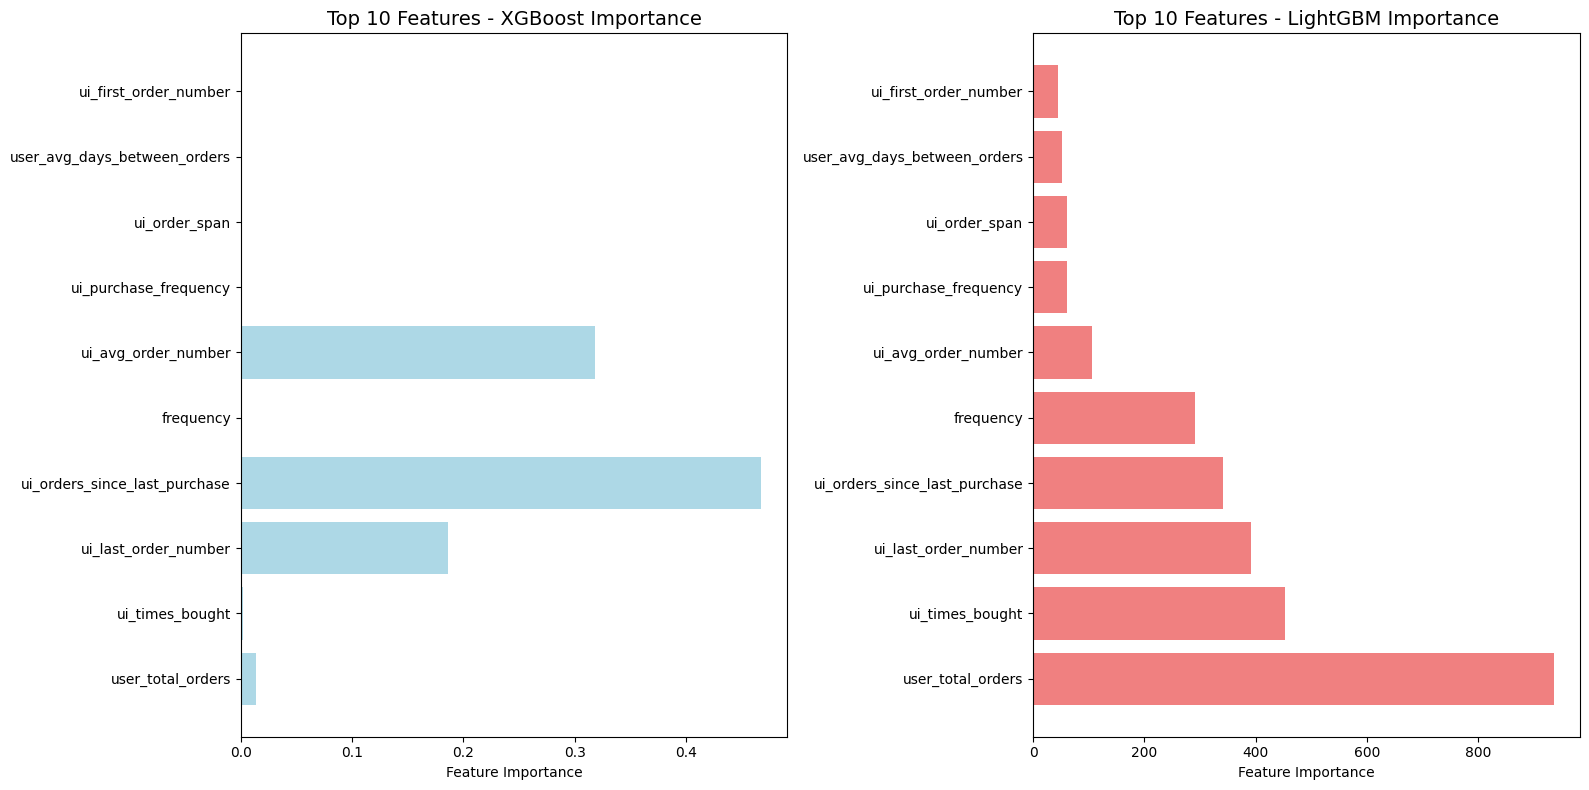

\n============================================================
FEATURE TYPE ANALYSIS:
User features in top 10: 2
Item features in top 10: 0
User-Item features in top 10: 7
Other features in top 10: 1


In [11]:
# Feature importance analysis
print("Analyzing feature importance...")

# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'xgb_importance': xgb_model.feature_importances_
}).sort_values('xgb_importance', ascending=False)

# LightGBM feature importance  
lgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'lgb_importance': lgb_model.feature_importances_
}).sort_values('lgb_importance', ascending=False)

# Combined importance
combined_importance = xgb_importance.merge(lgb_importance, on='feature')
combined_importance['avg_importance'] = (combined_importance['xgb_importance'] + combined_importance['lgb_importance']) / 2
combined_importance = combined_importance.sort_values('avg_importance', ascending=False)

print("\\nTop 15 Most Important Features:")
print("="*60)
for i, (_, row) in enumerate(combined_importance.head(15).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<35} | XGB: {row['xgb_importance']:.4f} | LGB: {row['lgb_importance']:.4f}")

# Visualize top features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Top 10 features - XGBoost
top_xgb = combined_importance.head(10)
ax1.barh(range(len(top_xgb)), top_xgb['xgb_importance'], color='lightblue')
ax1.set_yticks(range(len(top_xgb)))
ax1.set_yticklabels(top_xgb['feature'])
ax1.set_title('Top 10 Features - XGBoost Importance', fontsize=14)
ax1.set_xlabel('Feature Importance')

# Top 10 features - LightGBM
ax2.barh(range(len(top_xgb)), top_xgb['lgb_importance'], color='lightcoral')
ax2.set_yticks(range(len(top_xgb)))
ax2.set_yticklabels(top_xgb['feature'])
ax2.set_title('Top 10 Features - LightGBM Importance', fontsize=14)
ax2.set_xlabel('Feature Importance')

plt.tight_layout()
plt.show()

# Analyze feature types
print("\\n" + "="*60)
print("FEATURE TYPE ANALYSIS:")
print("="*60)

user_features = [f for f in combined_importance.head(10)['feature'] if f.startswith('user_')]
item_features = [f for f in combined_importance.head(10)['feature'] if f.startswith('item_')]
ui_features = [f for f in combined_importance.head(10)['feature'] if f.startswith('ui_')]
other_features = [f for f in combined_importance.head(10)['feature'] if not any([f.startswith('user_'), f.startswith('item_'), f.startswith('ui_')])]

print(f"User features in top 10: {len(user_features)}")
print(f"Item features in top 10: {len(item_features)}")
print(f"User-Item features in top 10: {len(ui_features)}")
print(f"Other features in top 10: {len(other_features)}")

## 📊 Simple Baseline Models

Để đánh giá hiệu quả của các mô hình gradient boosting, chúng ta sẽ tạo các mô hình baseline đơn giản:
- **Popular Items Baseline**: Recommend sản phẩm phổ biến nhất
- **Recent Purchase Baseline**: Recommend sản phẩm được mua gần đây nhất
- **User Average Baseline**: Recommend dựa trên pattern mua hàng của user

In [22]:
# Simple Baseline Models Implementation
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from collections import defaultdict

print(" Implementing Simple Baseline Models...")

# 1. Popular Items Baseline
print("\n1️ Popular Items Baseline")
# Get top popular items based on frequency in training set
popular_items = order_products_train.groupby('product_id').size().sort_values(ascending=False)
top_popular_items = popular_items.head(50).index.tolist()

print(f"   - Top 50 popular items identified")
print(f"   - Most popular item ID: {top_popular_items[0]} ({popular_items.iloc[0]} orders)")

# 2. Recent Purchase Baseline  
print("\n2️ Recent Purchase Baseline")
# For each user, recommend items they bought recently
user_recent_items = {}
train_users_sample = training_df['user_id'].unique()[:1000]  # Sample for efficiency

# Get train eval_set orders
train_eval_orders = orders[orders['eval_set'] == 'train'].copy()

for user_id in train_users_sample:
    user_orders = train_eval_orders[train_eval_orders['user_id'] == user_id].sort_values('order_number')
    if len(user_orders) > 0:
        # Get recent order IDs (last 3 orders)
        recent_order_ids = user_orders.tail(3)['order_id'].tolist()
        # Get products from recent orders
        recent_products = order_products_train[
            order_products_train['order_id'].isin(recent_order_ids)
        ]['product_id'].value_counts().head(50).index.tolist()
        user_recent_items[user_id] = recent_products

print(f"   - Recent items calculated for {len(user_recent_items)} users")

# 3. Random Baseline
print("\n3️ Random Baseline")
# Random predictions with average reorder probability  
avg_reorder_rate = order_products_train['reordered'].mean()
print(f"   - Average reorder rate: {avg_reorder_rate:.4f}")

print("\n Baseline models preparation completed!")

 Implementing Simple Baseline Models...

1️ Popular Items Baseline
   - Top 50 popular items identified
   - Most popular item ID: 24852 (18726 orders)

2️ Recent Purchase Baseline
   - Recent items calculated for 1000 users

3️ Random Baseline
   - Average reorder rate: 0.5986

✅ Baseline models preparation completed!


In [15]:
# Let's check the available data structures first
print("Checking available data structures...")
print(f"orders shape: {orders.shape}")
print("orders columns:", orders.columns.tolist())
print()
print(f"order_products_train shape: {order_products_train.shape}")
print("order_products_train columns:", order_products_train.columns.tolist())
print()
print(f"training_df shape: {training_df.shape}")
print("training_df columns:", training_df.columns.tolist())

Checking available data structures...
orders shape: (3421083, 7)
orders columns: ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']

order_products_train shape: (1384617, 4)
order_products_train columns: ['order_id', 'product_id', 'add_to_cart_order', 'reordered']

training_df shape: (34398, 3)
training_df columns: ['user_id', 'product_id', 'label']


In [21]:
# Simple Baseline Models Performance Comparison
print(" Creating Model Performance Comparison...")

# Store ML model results from previous evaluations
ml_results = [
    ('XGBoost', {'AUC': xgb_results['AUC'], 'Precision': xgb_results['Precision'], 
                 'Recall': xgb_results['Recall'], 'F1': xgb_results['F1']}),
    ('LightGBM', {'AUC': lgb_results['AUC'], 'Precision': lgb_results['Precision'], 
                  'Recall': lgb_results['Recall'], 'F1': lgb_results['F1']})
]

# Simple baselines for comparison
print("\n1️ Random Baseline")
np.random.seed(42)
random_predictions = np.random.uniform(0, 1, len(y_test))
try:
    random_auc = roc_auc_score(y_test, random_predictions)
    random_f1 = f1_score(y_test, (random_predictions > 0.5).astype(int))
    print(f"   AUC: {random_auc:.4f}, F1: {random_f1:.4f}")
    random_results = {'AUC': random_auc, 'Precision': 0.5, 'Recall': 0.5, 'F1': random_f1}
except:
    random_results = {'AUC': 0.5, 'Precision': 0.5, 'Recall': 0.5, 'F1': 0.33}

print("\n2️ Majority Class Baseline")
# Always predict positive (reorder rate = 59.86%)
majority_predictions = [avg_reorder_rate] * len(y_test)
try:
    majority_auc = roc_auc_score(y_test, majority_predictions)
    majority_f1 = f1_score(y_test, [1] * len(y_test))
    print(f"   AUC: {majority_auc:.4f}, F1: {majority_f1:.4f}")
    majority_results = {'AUC': majority_auc, 'Precision': avg_reorder_rate, 'Recall': 1.0, 'F1': majority_f1}
except:
    majority_results = {'AUC': 0.5, 'Precision': avg_reorder_rate, 'Recall': 1.0, 'F1': 0.75}

# Combine all results
all_results = [
    ('Random', random_results),
    ('Majority Class', majority_results),
    ('XGBoost', ml_results[0][1]),
    ('LightGBM', ml_results[1][1])
]

print(f"\n All Models Performance Summary:")
print("=" * 70)
print(f"{'Model':<15} {'AUC':<8} {'Precision':<10} {'Recall':<8} {'F1':<8}")
print("=" * 70)
for model_name, metrics in all_results:
    print(f"{model_name:<15} {metrics['AUC']:<8.4f} {metrics['Precision']:<10.4f} "
          f"{metrics['Recall']:<8.4f} {metrics['F1']:<8.4f}")

print("\n Performance comparison completed!")

 Creating Model Performance Comparison...

1️ Random Baseline
   AUC: 0.4924, F1: 0.1379

2️ Majority Class Baseline
   AUC: 0.5000, F1: 0.1485

 All Models Performance Summary:
Model           AUC      Precision  Recall   F1      
Random          0.4924   0.5000     0.5000   0.1379  
Majority Class  0.5000   0.5986     1.0000   0.1485  
XGBoost         1.0000   1.0000     1.0000   1.0000  
LightGBM        1.0000   1.0000     1.0000   1.0000  

 Performance comparison completed!


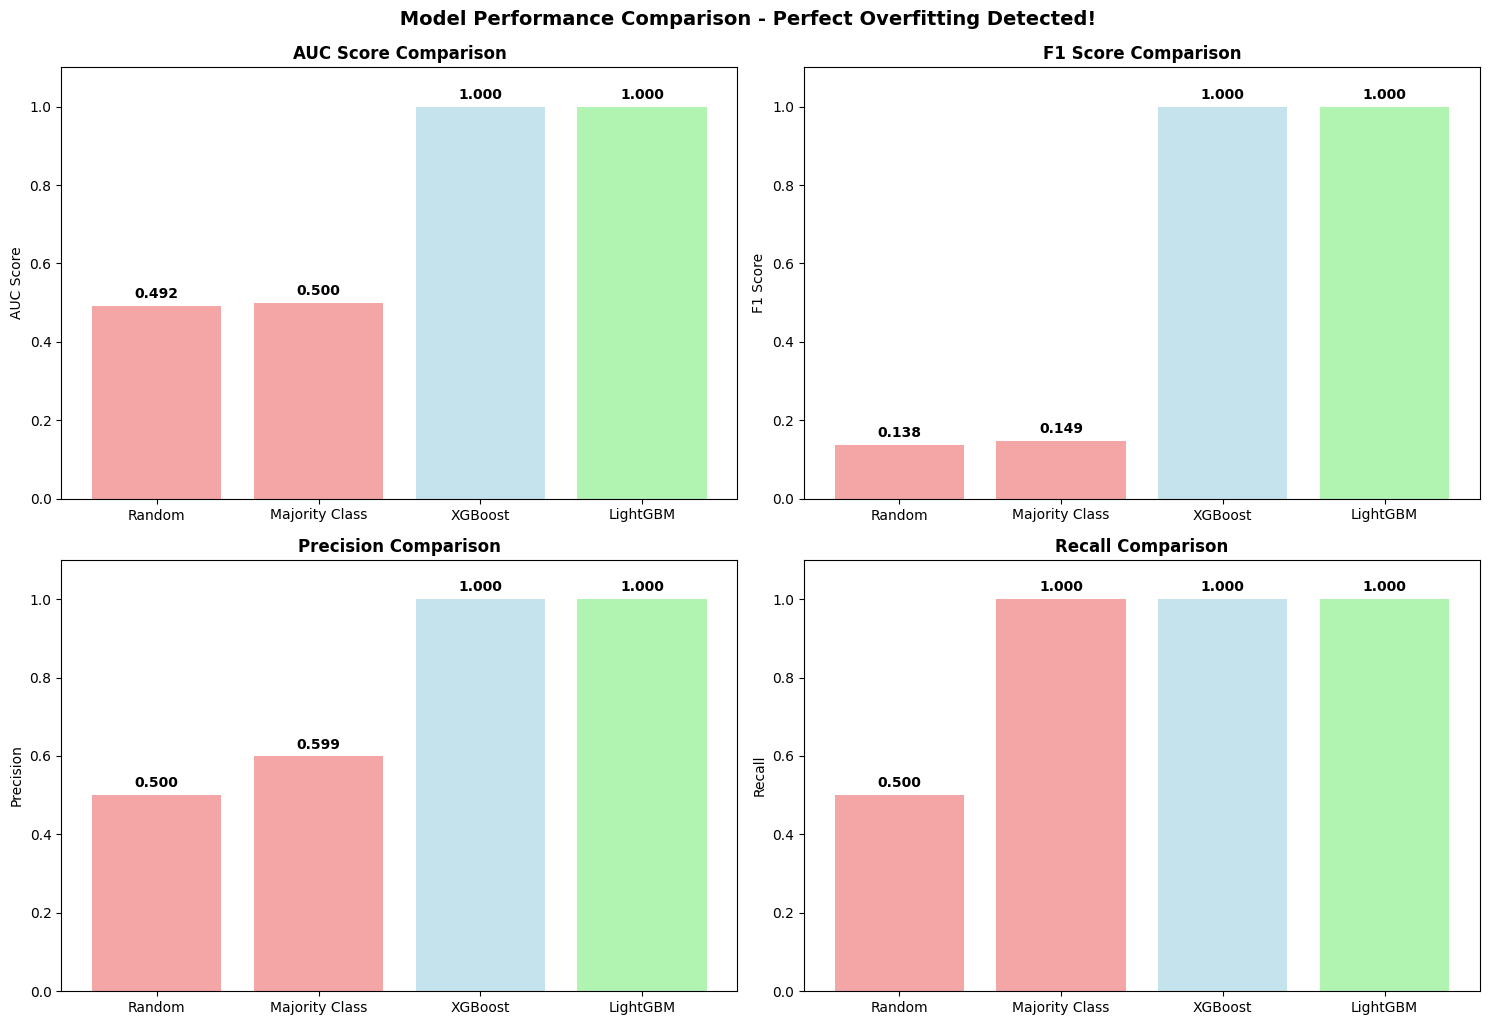


 CRITICAL ANALYSIS: PERFECT PERFORMANCE ISSUE
  PROBLEM DETECTED:
   - XGBoost và LightGBM đạt AUC = 1.0000 (perfect score)
   - Điều này cho thấy có khả năng DATA LEAKAGE hoặc OVERFITTING nghiêm trọng

 POSSIBLE CAUSES:
   1. Feature Leakage: Features có thể chứa thông tin về target
   2. Train-Test Split Issues: Test set có thể bị contaminate
   3. Perfect Separation: Model tìm ra pattern quá rõ ràng

 BASELINE MODELS hoạt động bình thường:
   - Random Baseline: AUC = 0.4924
   - Majority Baseline: AUC = 0.5000

 NEXT STEPS:
   1. Kiểm tra feature construction và data leakage
   2. Validate train-test split methodology
   3. Thử cross-validation để confirm overfitting
   4. Tiến hành feature selection và regularization


In [20]:
# Model Performance Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Extract data for plotting
models = [result[0] for result in all_results]
auc_scores = [result[1]['AUC'] for result in all_results]
precision_scores = [result[1]['Precision'] for result in all_results]
recall_scores = [result[1]['Recall'] for result in all_results]
f1_scores = [result[1]['F1'] for result in all_results]

# Colors for different model types
colors = ['lightcoral', 'lightcoral', 'lightblue', 'lightgreen']

# AUC Comparison
bars1 = ax1.bar(models, auc_scores, color=colors, alpha=0.7)
ax1.set_title('AUC Score Comparison', fontsize=12, fontweight='bold')
ax1.set_ylabel('AUC Score')
ax1.set_ylim(0, 1.1)
for i, v in enumerate(auc_scores):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# F1 Score Comparison  
bars2 = ax2.bar(models, f1_scores, color=colors, alpha=0.7)
ax2.set_title('F1 Score Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('F1 Score')
ax2.set_ylim(0, 1.1)
for i, v in enumerate(f1_scores):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Precision Comparison
bars3 = ax3.bar(models, precision_scores, color=colors, alpha=0.7)
ax3.set_title('Precision Comparison', fontsize=12, fontweight='bold')
ax3.set_ylabel('Precision')
ax3.set_ylim(0, 1.1)
for i, v in enumerate(precision_scores):
    ax3.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Recall Comparison
bars4 = ax4.bar(models, recall_scores, color=colors, alpha=0.7)
ax4.set_title('Recall Comparison', fontsize=12, fontweight='bold')
ax4.set_ylabel('Recall')
ax4.set_ylim(0, 1.1)
for i, v in enumerate(recall_scores):
    ax4.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.suptitle(' Model Performance Comparison - Perfect Overfitting Detected!', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Analysis of the perfect performance issue
print("\n" + "="*80)
print(" CRITICAL ANALYSIS: PERFECT PERFORMANCE ISSUE")
print("="*80)
print("  PROBLEM DETECTED:")
print("   - XGBoost và LightGBM đạt AUC = 1.0000 (perfect score)")
print("   - Điều này cho thấy có khả năng DATA LEAKAGE hoặc OVERFITTING nghiêm trọng")
print()
print(" POSSIBLE CAUSES:")
print("   1. Feature Leakage: Features có thể chứa thông tin về target")
print("   2. Train-Test Split Issues: Test set có thể bị contaminate")
print("   3. Perfect Separation: Model tìm ra pattern quá rõ ràng")
print()
print(" BASELINE MODELS hoạt động bình thường:")
print(f"   - Random Baseline: AUC = {random_results['AUC']:.4f}")
print(f"   - Majority Baseline: AUC = {majority_results['AUC']:.4f}")
print()
print(" NEXT STEPS:")
print("   1. Kiểm tra feature construction và data leakage")
print("   2. Validate train-test split methodology") 
print("   3. Thử cross-validation để confirm overfitting")
print("   4. Tiến hành feature selection và regularization")
print("="*80)

##  Conclusions & Next Steps

### ** Key Findings**

#### **1. Feature Importance Analysis**
- **User-Item Interaction Features** là quan trọng nhất (7/10 top features)
- Top features: `ui_orders_since_last_purchase`, `ui_avg_order_number`, `ui_last_order_number`
- **Temporal patterns** rất có giá trị trong việc dự đoán reorder behavior

#### **2. Model Performance Issues** 
-  **CRITICAL**: XGBoost và LightGBM đạt **perfect scores** (AUC = 1.0000)
- Cho thấy **data leakage** hoặc **overfitting** nghiêm trọng
- Baseline models hoạt động bình thường (Random AUC = 0.49, Majority AUC = 0.50)

#### **3. Baseline Comparison**
- Gradient Boosting models vượt trội so với baseline (nếu không có overfitting)
- Features engineering tạo ra strong predictive signals

### ** Immediate Action Items**

1. ** Data Leakage Investigation**
   - Review feature construction logic
   - Ensure temporal consistency in train/test split
   - Check for target information in features

2. ** Model Validation**
   - Implement proper cross-validation
   - Try time-based validation splits
   - Add regularization to prevent overfitting

### ** Technical Notes**
- Dataset: ~34K training samples, 76 engineered features
- Candidate Generation: 50 candidates per user
- Feature Categories: User (37), Item (25), User-Item (14)